# <center>CREDIT CARD FRAUD DETECTION USING MACHINE LEARNING METHODS</center>

 <p style="color:blue;">Nils LEFEUVRE - March 2020</p>

![](https://www.howardbank.com/sites/default/files/HB-SecurityCenter-DebCredCardSecurity-WEB.jpg)

## <center>Welcome on my notebook! </center>

Today, our objective is to create the best classifier for credit car fraud detection. To do it, we'll compare classification models from different methods :
* Logistic regression
* Support Vector Machine
* Bagging (Random Forest)
* Boosting (XGBoost)
* Neural Network (tensorflow/keras)

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. I decided to proceed to an undersampling strategy to re-balance the class.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data.

Here are some other notebooks that helped me build this one :
- https://www.kaggle.com/jdelamorena/recall-97-by-using-undersampling-neural-network
- https://www.kaggle.com/marbatlle/fraud-prediction-undersampling-and-svm

If you found this notebook helpful or you just liked it , some upvotes would be very appreciated !

### Importing packages and data

In [14]:
#importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [15]:
#importing data from kaggle
df = pd.read_csv(r"C:\\Users\\Computer\\AI-Q2-learning-resources\\datasets\\creditcard.csv")
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data processing and undersampling

Time is not needed for classification so I simply remove the feature from the dataset :

In [16]:
df = df.drop("Time", axis=1)

We need to standardize the 'Amount' feature before modelling. 
For that, we use the StandardScaler function from sklearn. Then, we just have to drop the old feature :

In [17]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

In [18]:
#standard scaling
df['std_Amount'] = scaler.fit_transform(df['Amount'].values.reshape (-1,1))

#removing Amount
df = df.drop("Amount", axis=1)

Now, let's have a look at the class :

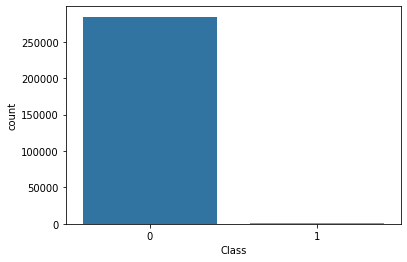

In [19]:
sns.countplot(x="Class", data=df)

The dataset is highly imbalanced ! 
It's a big problem because classifiers will always predict the most common class without performing any analysis of the features and it will have a high accuracy rate, obviously not the correct one. To change that, I will proceed to random undersampling.  

The simplest undersampling technique involves randomly selecting examples from the majority class and deleting them from the training dataset. This is referred to as random undersampling.

Although simple and effective, a limitation of this technique is that examples are removed without any concern for how useful or important they might be in determining the decision boundary between the classes. This means it is possible, or even likely, that useful information will be deleted.

### <center>How undersampling works :</center>
<center><img src= "https://miro.medium.com/max/335/1*YH_vPYQEDIW0JoUYMeLz_A.png">



To undersample, we can use the package imblearn with RandomUnderSampler function !

In [20]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler 

undersample = RandomUnderSampler(sampling_strategy=0.5)

In [21]:
cols = df.columns.tolist()
cols = [c for c in cols if c not in ["Class"]]
target = "Class"

In [22]:
#define X and Y
X = df[cols]
Y = df[target]

#undersample
X_under, Y_under = undersample.fit_resample(X, Y)

In [23]:
from pandas import DataFrame
test = pd.DataFrame(Y_under, columns = ['Class'])

Text(0.5, 1.0, 'After')

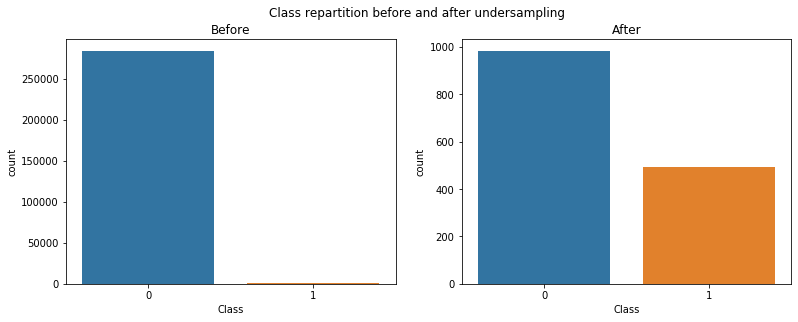

In [24]:
#visualizing undersampling results
fig, axs = plt.subplots(ncols=2, figsize=(13,4.5))
sns.countplot(x="Class", data=df, ax=axs[0])
sns.countplot(x="Class", data=test, ax=axs[1])

fig.suptitle("Class repartition before and after undersampling")
a1=fig.axes[0]
a1.set_title("Before")
a2=fig.axes[1]
a2.set_title("After")

Great ! Our dataset is now perfectly balanced !

The last step before modelling is now to split the data intro train and test samples. The test set will be composed of 20% of the data.

We will use the train dataset to train our models and then evaluate them of the test set : 
<center><img src= "https://data-flair.training/blogs/wp-content/uploads/sites/2/2018/08/1-16.png">

To split the data, we can use train_test_split function from sklearn !

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_under, Y_under, test_size=0.2, random_state=1)

Now we are ready for modeling ! Let's try to predict credit card frauds with different models. 

In [26]:
#importing packages for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

ModuleNotFoundError: No module named 'xgboost'

# 1. Logistic Regression

### <center> How Logistic regression works :

<center><img src= "https://saedsayad.com/images/LogReg_1.png">

In Logistic Regression, input values (X) are combined linearly using weights or coefficient values to predict an output value (y). 
A key difference from linear regression is that the output value being modeled is a binary values (0 or 1) rather than a numeric value. Logistic regression is a linear method, but the predictions are transformed using the logistic function.

In [ ]:
#train the model
model1 = LogisticRegression(random_state=2)
logit = model1.fit(X_train, y_train)

In [ ]:
#predictions
y_pred_logit = model1.predict(X_test) 

In [ ]:
#scores
print("Accuracy Logit:",metrics.accuracy_score(y_test, y_pred_logit))
print("Precision Logit:",metrics.precision_score(y_test, y_pred_logit))
print("Recall Logit:",metrics.recall_score(y_test, y_pred_logit))
print("F1 Score Logit:",metrics.f1_score(y_test, y_pred_logit))

In [ ]:
#print CM
matrix_logit = confusion_matrix(y_test, y_pred_logit)
cm_logit = pd.DataFrame(matrix_logit, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_logit, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix Logit"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [ ]:
#AUC
y_pred_logit_proba = model1.predict_proba(X_test)[::,1]
fpr_logit, tpr_logit, _ = metrics.roc_curve(y_test,  y_pred_logit_proba)
auc_logit = metrics.roc_auc_score(y_test, y_pred_logit_proba)
print("AUC Logistic Regression :", auc_logit)

In [ ]:
#ROC
plt.plot(fpr_logit,tpr_logit,label="Logistic Regression, auc={:.3f})".format(auc_logit))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve')
plt.legend(loc=4)
plt.show()

In [ ]:
logit_precision, logit_recall, _ = precision_recall_curve(y_test, y_pred_logit_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(logit_recall, logit_precision, color='orange', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

Classification metrics for Logistic Regression (rounded down) :
- Accuracy : 0.94
- F1 score : 0.92
- AUC : 0.96

# 2. Support Vector Machine

### <center> How SVM works : </center>

<center><img src= "https://vitalflux.com/wp-content/uploads/2020/07/Screenshot-2020-07-07-at-3.44.38-PM.png">

SVM Classifier uses a technique called the kernel trick to transform the data and then based on these transformations it finds an optimal boundary (hyper-plane) between the possible outputs.
Support vector machines focus only on the points that are the most difficult to tell apart, whereas other classifiers pay attention to all of the points.

In [ ]:
#train the model
model2 = SVC(probability=True, random_state=2)
svm = model2.fit(X_train, y_train)

In [ ]:
#predictions
y_pred_svm = model2.predict(X_test)

In [ ]:
#scores
print("Accuracy SVM:",metrics.accuracy_score(y_test, y_pred_svm))
print("Precision SVM:",metrics.precision_score(y_test, y_pred_svm))
print("Recall SVM:",metrics.recall_score(y_test, y_pred_svm))
print("F1 Score SVM:",metrics.f1_score(y_test, y_pred_svm))

In [ ]:
#CM matrix
matrix_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm = pd.DataFrame(matrix_svm, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_svm, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix SVM"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [ ]:
#AUC
y_pred_svm_proba = model2.predict_proba(X_test)[::,1]
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_test,  y_pred_svm_proba)
auc_svm = metrics.roc_auc_score(y_test, y_pred_svm_proba)
print("AUC SVM :", auc_svm)

In [ ]:
#ROC
plt.plot(fpr_svm,tpr_svm,label="SVM, auc={:.3f})".format(auc_svm))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('SVM ROC curve')
plt.legend(loc=4)
plt.show()

In [ ]:
svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_pred_svm_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(svm_recall, svm_precision, color='orange', label='SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

Classification metrics for SVM (rounded down) :
- Accuracy : 0.94
- F1 score : 0.92
- AUC : 0.97

# 3. Ensemble learning : Bagging (Random Forest)

### <center> How Random Forest works : </center>

<center><img src= "https://miro.medium.com/max/567/1*Mb8awDiY9T6rsOjtNTRcIg.png">

<center>"A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models"</center>

Random forest consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction.

In [ ]:
#train the model
model3 = RandomForestClassifier(random_state=2)
rf = model3.fit(X_train, y_train)

In [ ]:
#predictions
y_pred_rf = model3.predict(X_test)

In [ ]:
#scores
print("Accuracy RF:",metrics.accuracy_score(y_test, y_pred_rf))
print("Precision RF:",metrics.precision_score(y_test, y_pred_rf))
print("Recall RF:",metrics.recall_score(y_test, y_pred_rf))
print("F1 Score RF:",metrics.f1_score(y_test, y_pred_rf))

In [ ]:
#CM matrix
matrix_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf = pd.DataFrame(matrix_rf, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_rf, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix RF"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [ ]:
#AUC
y_pred_rf_proba = model3.predict_proba(X_test)[::,1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test,  y_pred_rf_proba)
auc_rf = metrics.roc_auc_score(y_test, y_pred_rf_proba)
print("AUC Random Forest :", auc_rf)

In [ ]:
#ROC
plt.plot(fpr_rf,tpr_rf,label="Random Forest, auc={:.3f})".format(auc_rf))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest ROC curve')
plt.legend(loc=4)
plt.show()

In [ ]:
rf_precision, rf_recall, _ = precision_recall_curve(y_test, y_pred_rf_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(rf_recall, rf_precision, color='orange', label='RF')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

Classification metrics for Random Forest (rounded down) :
- Accuracy : 0.95
- F1 score : 0.93
- AUC : 0.97

# 4. Ensemble learning : Boosting (XGBoost)

### <center> How XGBoost works :</center>

![](https://d1rwhvwstyk9gu.cloudfront.net/2020/02/XG-Boost-FINAL-01.png)

The sequential ensemble methods, also known as “boosting”, creates a sequence of models that attempt to correct the mistakes of the models before them in the sequence. The first model is built on training data, the second model improves the first model, the third model improves the second, and so on. 

In [ ]:
#train the model
model4 = XGBClassifier(random_state=2)
xgb = model4.fit(X_train, y_train)

In [ ]:
#predictions
y_pred_xgb = model4.predict(X_test) 

In [ ]:
#scores
print("Accuracy XGB:",metrics.accuracy_score(y_test, y_pred_xgb))
print("Precision XGB:",metrics.precision_score(y_test, y_pred_xgb))
print("Recall XGB:",metrics.recall_score(y_test, y_pred_xgb))
print("F1 Score XGB:",metrics.f1_score(y_test, y_pred_xgb))

In [ ]:
#CM matrix
matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_xgb = pd.DataFrame(matrix_xgb, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_xgb, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix XGBoost"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [ ]:
#AUC
y_pred_xgb_proba = model4.predict_proba(X_test)[::,1]
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test,  y_pred_xgb_proba)
auc_xgb = metrics.roc_auc_score(y_test, y_pred_xgb_proba)
print("AUC XGBoost :", auc_xgb)

In [ ]:
#ROC
plt.plot(fpr_xgb,tpr_xgb,label="XGBoost, auc={:.3f})".format(auc_xgb))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('XGBoost ROC curve')
plt.legend(loc=4)
plt.show()

In [ ]:
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, y_pred_xgb_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(xgb_recall, xgb_precision, color='orange', label='XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

Classification metrics for XGBoost (rounded down) :
- Accuracy : 0.95
- F1 score : 0.93
- AUC : 0.97

# 5. Multi Layer Perceptron

### <center> How Neural network works : </center>

<center><img src= "https://victorzhou.com/27cf280166d7159c0465a58c68f99b39/network3.svg">

The layers of a neural network are made of nodes. 
A node combines input from the data with a set of coefficients and bias, that either amplify or dampen that input, thereby assigning significance to inputs with regard to the task the algorithm is trying to learn. These input-weight products are summed and then the sum is passed through a node’s so-called activation function, to determine whether and to what extent that signal should progress further through the network to affect the ultimate outcome, say, an act of classification. If the signals passes through, the neuron has been “activated.”

In [ ]:
#train the model
model5 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100,100), random_state=2)
mlp = model5.fit(X_train, y_train)

In [ ]:
model5.get_params(deep=True)

In [ ]:
#predictions
y_pred_mlp = model5.predict(X_test)

In [ ]:
#scores
print("Accuracy MLP:",metrics.accuracy_score(y_test, y_pred_mlp))
print("Precision MLP:",metrics.precision_score(y_test, y_pred_mlp))
print("Recall MLP:",metrics.recall_score(y_test, y_pred_mlp))
print("F1 Score MLP:",metrics.f1_score(y_test, y_pred_mlp))

In [ ]:
#CM matrix
matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
cm_mlp = pd.DataFrame(matrix_mlp, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_mlp, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix MLP"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [ ]:
#AUC
y_pred_mlp_proba = model5.predict_proba(X_test)[::,1]
fpr_mlp, tpr_mlp, _ = metrics.roc_curve(y_test,  y_pred_mlp_proba)
auc_mlp = metrics.roc_auc_score(y_test, y_pred_mlp_proba)
print("AUC MLP :", auc_mlp)

In [ ]:
#ROC
plt.plot(fpr_mlp,tpr_mlp,label="MLPC, auc={:.3f})".format(auc_mlp))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Multilayer Perceptron ROC curve')
plt.legend(loc=4)
plt.show()

In [ ]:
mlp_precision, mlp_recall, _ = precision_recall_curve(y_test, y_pred_mlp_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(mlp_recall, mlp_precision, color='orange', label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

Classification metrics for Multi Layer Perceptron (rounded down) :
- Accuracy : 0.95
- F1 score : 0.94
- AUC : 0.98

# 6. Multilayer Neural Network with Tensorflow/Keras

In [ ]:
#train the model
model = Sequential()
model.add(Dense(32, input_shape=(29,), activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(16, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(8, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(4, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(1, activation='sigmoid'))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001) #optimizer

model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy']) #metrics

In [ ]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1,mode='auto', baseline=None, restore_best_weights=False)

In [ ]:
history = model.fit(X_train.values, y_train.values, epochs = 6, batch_size=5, validation_split = 0.15, verbose = 0,
                    callbacks = [earlystopper])
history_dict = history.history

In [ ]:
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

In [ ]:
accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.plot(val_accuracy_values,'-r',label='val_accuracy')
plt.plot(accuracy_values,'-b',label='accuracy')
plt.legend()
plt.xlabel("Epochs")

In [ ]:
#predictions
y_pred_nn = model.predict_classes(X_test)

In [ ]:
#scores
print("Accuracy Neural Net:",metrics.accuracy_score(y_test, y_pred_nn))
print("Precision Neural Net:",metrics.precision_score(y_test, y_pred_nn))
print("Recall Neural Net:",metrics.recall_score(y_test, y_pred_nn))
print("F1 Score Neural Net:",metrics.f1_score(y_test, y_pred_nn))

In [ ]:
#CM matrix
matrix_nn = confusion_matrix(y_test, y_pred_nn)
cm_nn = pd.DataFrame(matrix_nn, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_nn, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix Neural Network"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [ ]:
#AUC
y_pred_nn_proba = model.predict_proba(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,y_pred_nn_proba)
auc_keras = auc(fpr_keras, tpr_keras)
print('AUC Neural Net: ', auc_keras)

In [ ]:
#ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Neural Net ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
nn_precision, nn_recall, _ = precision_recall_curve(y_test, y_pred_nn_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(nn_recall, nn_precision, color='orange', label='TF NN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

Now let's visualize our multilayer network. 

The hidden layers are composed of an activation function called ReLU. It'is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. The last node has a sigmoid function that turns values to 0 or 1 (for binary classification).

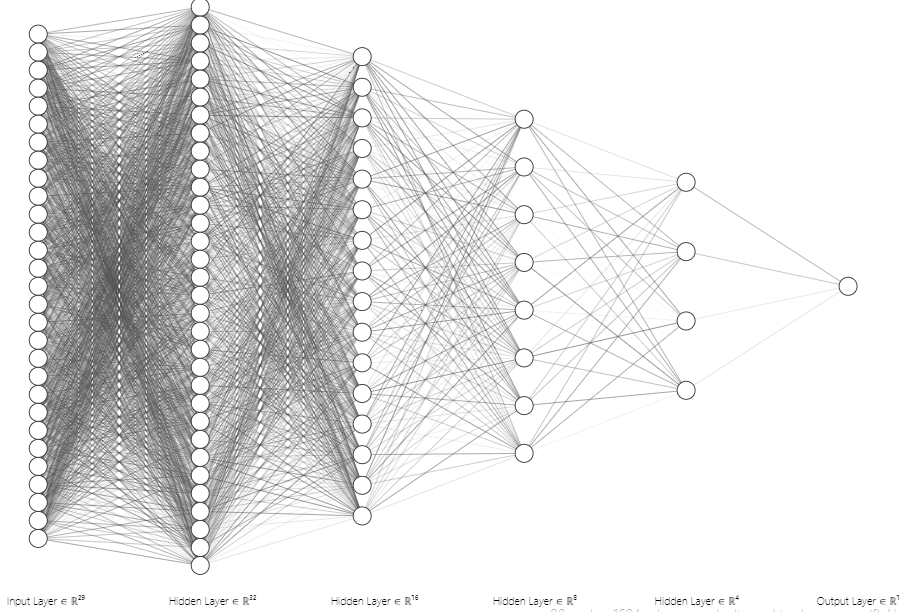

Classification metrics for Neural Network (rounded down) :
- Accuracy : 0.95
- F1 score : 0.94
- AUC : 0.98

# <center>And the winner is...</center>

<center><img src= "https://media.istockphoto.com/vectors/best-simple-champion-cup-winner-trophy-award-and-victory-vector-id1025281982?k=6&m=1025281982&s=612x612&w=0&h=Oos26qFlAJI7GG62Gs_k_aWRthTVJOsVKGx7AXVc6W8=">

# <center> Neural Network !!!</center>

The multilayer neural network has the best performance according to our three most important classification metrics (Accuracy, F1-score and AUC). The Multi Layer Perceptron from sklearn is the one that minimizes the most the false negatives so I decided to keep this model to predict credit card frauds. It's very important that a bank do not miss frauds so minimizing false negatives rate is essential. 

All the models can be improved by tuning hyper-parameters. Please upvote this notebook if you want me to update it with model tuning ! 